# Explanation tables

Propriedades de uma Explanation Table
<ul>
   <li>Informativa</li>
    <ul>
        <li>Solapáveis</li>
    </ul>
   <li>Interpretável</li>
   <li>Eficiente</li>
</ul>

In [1]:
#Livrarias
import numpy as np
import pandas as pd
import itertools

## Dataset

In [2]:
#Data
day = ['Fri', 'Fri', 'Sun', 'Sun', 'Mon', 'Mon', 'Tue', 'Wed', 'Thu', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat'];
time = ['Dawn', 'Night', 'Dusk', 'Morning', 'Afternoon', 'Midday', 'Morning', 'Night', 'Dawn', 'Afternoon', 'Dawn', 'Dawn', 'Dusk', 'Midday'];
meal = ['Banana', 'Green Salad', 'Oatmeal', 'Banana', 'Oatmeal', 'Banana', 'Green Salad', 'Burgers', 'Oatmeal', 'Nuts', 'Banana', 'Oatmeal', 'Rice', 'Toast'];

#Dataset
dataset = pd.DataFrame({
  'day'  : day,
  'time' : time,
  'meal' : meal
}); 

In [3]:
dataset

,day,time,meal
0,Fri,Dawn,Banana
1,Fri,Night,Green Salad
2,Sun,Dusk,Oatmeal
3,Sun,Morning,Banana
4,Mon,Afternoon,Oatmeal
5,Mon,Midday,Banana
6,Tue,Morning,Green Salad
7,Wed,Night,Burgers
8,Thu,Dawn,Oatmeal
9,Sat,Afternoon,Nuts


In [4]:
#Binary data
goal = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No'];
#Augmented dataset 
dataset['goal'] = goal;

In [5]:
dataset

,day,time,meal,goal
0,Fri,Dawn,Banana,Yes
1,Fri,Night,Green Salad,Yes
2,Sun,Dusk,Oatmeal,Yes
3,Sun,Morning,Banana,Yes
4,Mon,Afternoon,Oatmeal,Yes
5,Mon,Midday,Banana,Yes
6,Tue,Morning,Green Salad,No
7,Wed,Night,Burgers,No
8,Thu,Dawn,Oatmeal,Yes
9,Sat,Afternoon,Nuts,No


## Pre-processamento

In [6]:
#Funções e estruturas axuiliares

#rows - Rows from which obtain the keys of the returned dictionary [dic]
def addKeyValue(rows):
    dic = {};
    uniqueList = rows.unique();
    for val,key in enumerate(uniqueList):
        dic.update({key : val});
    return dic;

def createSolutionSpace(D):
    columns = D.columns;
    _,nC = D.shape;
    dicUniqueCols = {};
    for k, col in enumerate(columns[:-1]):
        dicUniqueCols.update({k : np.append(D[col].unique(),-1)});
    dicUniqueCols.update({nC:[0]}) 
    return pd.DataFrame(np.array(list(itertools.product(*dicUniqueCols.values()))));

#Times of apparitions of x in the dataset
def countApparitions(D,x):
    nRows,_= D.shape;
    res = [True for x in range(nRows)];
    for header in D.columns:
        res &= D[header] == x[header]
    return res.sum()/nRows;

#Calculate the empirical distribution for x in the dataset D
def empirical(D, label):
    res = pd.DataFrame({
      label : D.apply(lambda x:countApparitions(D,x), axis=1)
    });
    return res;

#Creating dictionaries
dicDay  = addKeyValue(dataset['day']);
dicTime = addKeyValue(dataset['time']);
dicMeal = addKeyValue(dataset['meal']);
dicGoal = addKeyValue(dataset['goal']);
#Coding table
codedDay   = dataset['day'].apply(lambda x: dicDay[x]);
codedTime  = dataset['time'].apply(lambda x: dicTime[x]);
codedMeal  = dataset['meal'].apply(lambda x: dicMeal[x]);
codedGoal  = dataset['goal'].apply(lambda x: dicGoal[x]);

In [7]:
#Coded dataset
codedDataset = pd.DataFrame({
  'day'  : codedDay,
  'time' : codedTime,
  'meal' : codedMeal,
  'goal' : 1-codedGoal
});

In [8]:
codedDataset

,day,time,meal,goal
0,0,0,0,1
1,0,1,1,1
2,1,2,2,1
3,1,3,0,1
4,2,4,2,1
5,2,5,0,1
6,3,3,1,0
7,4,1,3,0
8,5,0,2,1
9,6,4,4,0


In [9]:
#Espaço de soluções
solSpace = createSolutionSpace(codedDataset);
solSpace

,0,1,2,3
0,0,0,0,0
1,0,0,1,0
2,0,0,2,0
3,0,0,3,0
4,0,0,4,0
...,...,...,...,...
443,-1,-1,3,0
444,-1,-1,4,0
445,-1,-1,5,0
446,-1,-1,6,0


In [10]:
#Extend the codedDataset
###Add empirical probability p(x) to the patterns x
metaColumns = -1; #columns in D that are not part of the pattern, dedicated for calculations
res = empirical(codedDataset.iloc[:,:metaColumns], 'empX'); #calculate empirical distribution
codedDataset = pd.concat([codedDataset,res], axis=1); #add empirical column to the dataset
metaColumns -= 1 #update metacolumns
###Add joint probability p(x,v) to the patterns x with goal value v
res = empirical(codedDataset.iloc[:, :metaColumns+1], 'empXY');
codedDataset = pd.concat([codedDataset,res], axis=1); #add empirical joint probability column to the dataset
metaColumns -= 1 #update metacolumns

In [11]:
codedDataset

,day,time,meal,goal,empX,empXY
0,0,0,0,1,0.071429,0.071429
1,0,1,1,1,0.071429,0.071429
2,1,2,2,1,0.071429,0.071429
3,1,3,0,1,0.071429,0.071429
4,2,4,2,1,0.071429,0.071429
5,2,5,0,1,0.071429,0.071429
6,3,3,1,0,0.071429,0.071429
7,4,1,3,0,0.071429,0.071429
8,5,0,2,1,0.071429,0.071429
9,6,4,4,0,0.071429,0.071429


In [12]:
#From pandas to numpy
codedDataset = codedDataset.to_numpy();
solSpace = solSpace.to_numpy();

Reduzindo o espaço de soluções

In [13]:
#t tuple of size n from the dataset
#p pattern of size n from the explanation table
#match(t,p)=1 if they match
def match(t,p):
    n = len(t);
    for i in range(n):
        if not((t[i] == p[i]) or (p[i] == -1)):
            return False;
    return True;

auxSolSpace = [];
for sol in solSpace:
    countMatch = 0;
    for d in codedDataset:
        countMatch += match(d[:-3], sol[:-1]);
    if countMatch > 0:
        auxSolSpace.append(sol);
solSpace = np.array(auxSolSpace);

In [14]:
codedDataset

array([[0.        , 0.        , 0.        , 1.        , 0.07142857,
        0.07142857],
       [0.        , 1.        , 1.        , 1.        , 0.07142857,
        0.07142857],
       [1.        , 2.        , 2.        , 1.        , 0.07142857,
        0.07142857],
       [1.        , 3.        , 0.        , 1.        , 0.07142857,
        0.07142857],
       [2.        , 4.        , 2.        , 1.        , 0.07142857,
        0.07142857],
       [2.        , 5.        , 0.        , 1.        , 0.07142857,
        0.07142857],
       [3.        , 3.        , 1.        , 0.        , 0.07142857,
        0.07142857],
       [4.        , 1.        , 3.        , 0.        , 0.07142857,
        0.07142857],
       [5.        , 0.        , 2.        , 1.        , 0.07142857,
        0.07142857],
       [6.        , 4.        , 4.        , 0.        , 0.07142857,
        0.07142857],
       [6.        , 0.        , 0.        , 0.        , 0.07142857,
        0.07142857],
       [6.        , 0

In [15]:
solSpace

array([[ 0,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  1,  1,  0],
       [ 0,  1, -1,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  1,  0],
       [ 0, -1, -1,  0],
       [ 1,  2,  2,  0],
       [ 1,  2, -1,  0],
       [ 1,  3,  0,  0],
       [ 1,  3, -1,  0],
       [ 1, -1,  0,  0],
       [ 1, -1,  2,  0],
       [ 1, -1, -1,  0],
       [ 2,  4,  2,  0],
       [ 2,  4, -1,  0],
       [ 2,  5,  0,  0],
       [ 2,  5, -1,  0],
       [ 2, -1,  0,  0],
       [ 2, -1,  2,  0],
       [ 2, -1, -1,  0],
       [ 3,  3,  1,  0],
       [ 3,  3, -1,  0],
       [ 3, -1,  1,  0],
       [ 3, -1, -1,  0],
       [ 4,  1,  3,  0],
       [ 4,  1, -1,  0],
       [ 4, -1,  3,  0],
       [ 4, -1, -1,  0],
       [ 5,  0,  2,  0],
       [ 5,  0, -1,  0],
       [ 5, -1,  2,  0],
       [ 5, -1, -1,  0],
       [ 6,  0,  0,  0],
       [ 6,  0,  2,  0],
       [ 6,  0, -1,  0],
       [ 6,  2,  5,  0],
       [ 6,  2, -1,  0],
       [ 6,  4,  4,  0],
       [ 6,  4, -1,  0],


## Baseline Algorithm

In [16]:
def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    #Repetir k vezes
        #Obter o padrão p_max que maximize a entropia
        #Agregar p_max como padrão a T
    #Atualizar as estimações u* com o novo padrão p_max agregado a T
    #Retornar u*, T
    pass

Primeira atualização -> Iniciar Explanation Table T com o padrão ( *, *,..., *)

In [17]:
#Get the all-wildcard pattern from 
def getAllWildcard(solSpace):
    _,nC = solSpace.shape;
    patterns = solSpace[:,:-1]; #Get the pattern columns
    arraySum = np.sum(patterns, axis=1) #Sum all the values for each pattern
    index = np.where(arraySum == -(nC-1))[0] #Get the index where the all=wildcard resides
    solSpace[index, -1] = 1; #Mark the pattern as added
    return solSpace[index,:-1][0] #Return the pattern

In [18]:
def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    p = getAllWildcard(solSpace)
    T = np.array([p]);
    return T
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    #Repetir k vezes
      #Obter o padrão p_max que maximize a entropia
      #Agregar p_max como padrão a T
    #Atualizar as estimações u* com o novo padrão p_max agregado a T
    #Retornar u*, T

In [19]:
print(explanationTable(codedDataset,3));

[[-1 -1 -1]]


Segunda atualização - > Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T

In [20]:
def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    p = getAllWildcard(solSpace)
    T = np.array([p]);
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    nR,nC = D.shape;
    initialEstimation = np.sum(D[:,-3])/nR;
    U = np.array([initialEstimation for _ in range(nR)]);
    return(U);
    #Repetir k vezes
      #Obter o padrão p_max que maximize a entropia
      #Agregar p_max como padrão a T
    #Atualizar as estimações u* com o novo padrão p_max agregado a T
    #Retornar u*, T

In [21]:
print(explanationTable(codedDataset,3));

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


Terceira atualização - > Pesquisar a solução no espaço de soluções

In [22]:
def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    p = getAllWildcard(solSpace)
    T = np.array([p]);
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    nR,nC = D.shape;
    initialEstimation = np.sum(D[:,-3])/nR;
    U = np.array([initialEstimation for _ in range(nR)]);
    #Repetir k vezes
    for i in range(k):
        mask = np.where(solSpace[:,-1] == 0); #Get the unmarked patterns
       #Obter o padrão p_max que maximize a entropia
        for index, pCandidate in enumerate(solSpace[mask][:,:-1]): #For each candidate
            print('Candidato {}: {}'.format(index, pCandidate));
        break;
       #Agregar p_max como padrão a T
       #Atualizar as estimações u* com o novo padrão p_max agregado a T
    #Retornar u*, T
    return;

In [23]:
explanationTable(codedDataset,3)

Candidato 0: [0 0 0]
Candidato 1: [ 0  0 -1]
Candidato 2: [0 1 1]
Candidato 3: [ 0  1 -1]
Candidato 4: [ 0 -1  0]
Candidato 5: [ 0 -1  1]
Candidato 6: [ 0 -1 -1]
Candidato 7: [1 2 2]
Candidato 8: [ 1  2 -1]
Candidato 9: [1 3 0]
Candidato 10: [ 1  3 -1]
Candidato 11: [ 1 -1  0]
Candidato 12: [ 1 -1  2]
Candidato 13: [ 1 -1 -1]
Candidato 14: [2 4 2]
Candidato 15: [ 2  4 -1]
Candidato 16: [2 5 0]
Candidato 17: [ 2  5 -1]
Candidato 18: [ 2 -1  0]
Candidato 19: [ 2 -1  2]
Candidato 20: [ 2 -1 -1]
Candidato 21: [3 3 1]
Candidato 22: [ 3  3 -1]
Candidato 23: [ 3 -1  1]
Candidato 24: [ 3 -1 -1]
Candidato 25: [4 1 3]
Candidato 26: [ 4  1 -1]
Candidato 27: [ 4 -1  3]
Candidato 28: [ 4 -1 -1]
Candidato 29: [5 0 2]
Candidato 30: [ 5  0 -1]
Candidato 31: [ 5 -1  2]
Candidato 32: [ 5 -1 -1]
Candidato 33: [6 0 0]
Candidato 34: [6 0 2]
Candidato 35: [ 6  0 -1]
Candidato 36: [6 2 5]
Candidato 37: [ 6  2 -1]
Candidato 38: [6 4 4]
Candidato 39: [ 6  4 -1]
Candidato 40: [6 5 6]
Candidato 41: [ 6  5 -1]
Ca

Quarta atualização - > Lógica para pesquisar o melhor candidato

In [24]:
def iterativeScaling(T,D,lambdas):
    #Mock
    nLambdas = len(lambdas);  
    nR,_=D.shape;
    mockLambdas = np.random.uniform(-10,10,nLambdas);
    mockEstimation = np.random.uniform(0,1,nR);
    return mockLambdas, mockEstimation;

def gainFunction(T,D,lambdas):
    #Mock
    mockGain = np.random.uniform(-4,0,1);
    return mockGain;

def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    p = getAllWildcard(solSpace)
    T = np.array([p]);
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    nR,nC = D.shape;
    initialEstimation = np.sum(D[:,-3])/nR;
    U = np.array([initialEstimation for _ in range(nR)]);
    lambdas = [0] #Oh yes! This will be a lagrangian relaxation
    pastLogLH = 0;#Best past gain
    #Repetir k vezes
    for i in range(k):
        mask = np.where(solSpace[:,-1] == 0); #Get the unmarked patterns
        logLHArray = np.zeros(len(mask[0]));#Preparing the array to collect the gains
        #Obter o padrão p_max que maximize a entropia
        for index, pCandidate in enumerate(solSpace[mask][:,:-1]): #For each candidate
            #Optimization problem
            TCandidate = np.append(T,[pCandidate], axis=0); #Go to the optimization problem with the actual chosen patterns and with the candidate pCandidate
            lambdasCandidate, _ = iterativeScaling(TCandidate, D, np.append(lambdas, [0]));#Optimize engineer!
            logLHArray[index] = gainFunction(TCandidate, D, lambdasCandidate); #Compute the gain for these lambdas   
       #Agregar p_max como padrão a T
       #Atualizar as estimações u* com o novo padrão p_max agregado a T
    #Retornar u*, T
    return;

Quinta atualizção - > Escolher o padrão com o maior ganho, agregar o padrão à Explanation Table, re-computar as estimações e os lambdas

In [25]:
def explanationTable(D,k):
    #Iniciar Explanation Table T com o padrão (*,*,...,*)
    p = getAllWildcard(solSpace)
    T = np.array([p]);
    #Iniciar estimação u*, com u*[i] = sum(meta)/N, sendo N o tamanho de T
    nR,nC = D.shape;
    initialEstimation = np.sum(D[:,-3])/nR;
    U = np.array([initialEstimation for _ in range(nR)]);
    lambdas = [0] #Oh yes! This will be a lagrangian relaxation
    pastLogLH = 0;#Best past gain
    #Repetir k vezes
    for i in range(k):
        mask = np.where(solSpace[:,-1] == 0); #Get the unmarked patterns
        logLHArray = np.zeros(len(mask[0]));#Preparing the array to collect the gains
        #Obter o padrão p_max que maximize a entropia
        for index, pCandidate in enumerate(solSpace[mask][:,:-1]): #For each candidate
            #Optimization problem
            TCandidate = np.append(T,[pCandidate], axis=0); #Go to the optimization problem with the actual chosen patterns and with the candidate pCandidate
            lambdasCandidate, _ = iterativeScaling(TCandidate, D, np.append(lambdas, [0]));#Optimize engineer!
            logLHArray[index] = gainFunction(TCandidate, D, lambdasCandidate); #Compute the gain for these lambdas   
        #Agregar p_max como padrão a T
        indexGain = np.argmax(logLHArray); #Obtain the index gain
        T = np.append(T, [solSpace[indexGain][:-1]], axis=0); #Add the new pattern to the Explanation Table
        solSpace[indexGain,-1] = 1; #Mark the new added pattern
        pastLogLH = logLHArray[indexGain] + pastLogLH; #Update the current gain
        #Atualizar as estimações u* com o novo padrão p_max agregado a T
        lambdas, U = iterativeScaling(T, D, np.append(lambdas, [0]));#Update lambda and the estimation
    #Retornar u*, T
    return T,U;    

In [26]:
T,U = explanationTable(codedDataset,3)

In [27]:
T

array([[-1, -1, -1],
       [ 1, -1,  2],
       [-1,  3,  0],
       [-1, -1,  4]], dtype=int64)

In [28]:
U

array([0.26489725, 0.24226903, 0.93944711, 0.72700845, 0.30817817,
       0.16222882, 0.91625714, 0.39790861, 0.71518132, 0.83687349,
       0.25336494, 0.71513356, 0.10029132, 0.27583526])

## Alguns resultados

In [38]:
import matplotlib.pyplot as plt 

In [39]:
newtonBaseLineMS = [1103.5327, 1250.5308, 1461.4857, 1495.3486]
newtonBaseLineGain = [4.1993243995696625, 3.05580156625466, 2.216265600374897, 1.556835911542484]

polinomialBaseLineMS = [9289.0021, 16210.4953, 24518.3215, 36200.1083]
polinomialBaseLineGain = [0.8813656291237169, 0.8814817770872216, 0.8815584312351925, 0.8818785429366502 ]

flashLightMS = np.array([
    [579.4286 , 541.7452,  550.0778], 
    [658.2021 , 612.444, 646.0027],
    [630.4624 , 606.3839, 537.0084]
]);
flashLightGain = np.array([
    [8.298891265336568, 5.581415440661885, 10.41276376567507],
    [5.31291027405618 , 9.656821703328625, 5.31291027405618],
    [8.437345739998012, 8.43734537259843, 6.102711988267998 ]  
]);

meanFlashLightMS = np.mean(flashLightMS, axis=0)
meanFlashLightGain = np.mean(flashLightGain, axis=0)

flashLightMSS4 = np.array([608.1699,  642.7105, 595.7134]);
flashLightGainS4 = np.array([4.858503815917721,  5.31291027405618, 8.369347665984655]);

flashLightMSS5 = np.array([589.8094, 598.1593, 536.9648]);
flashLightGainS5 = np.array([8.369347665984655,  8.462969048139938, 4.858503815917721]);

meanFlashLightMSS4 = np.mean(flashLightMSS4, axis=0)
meanFlashLightGainS4 = np.mean(flashLightGainS4, axis=0)

meanFlashLightMSS5 = np.mean(flashLightMSS5, axis=0)
meanFlashLightGainS5 = np.mean(flashLightGainS5, axis=0)

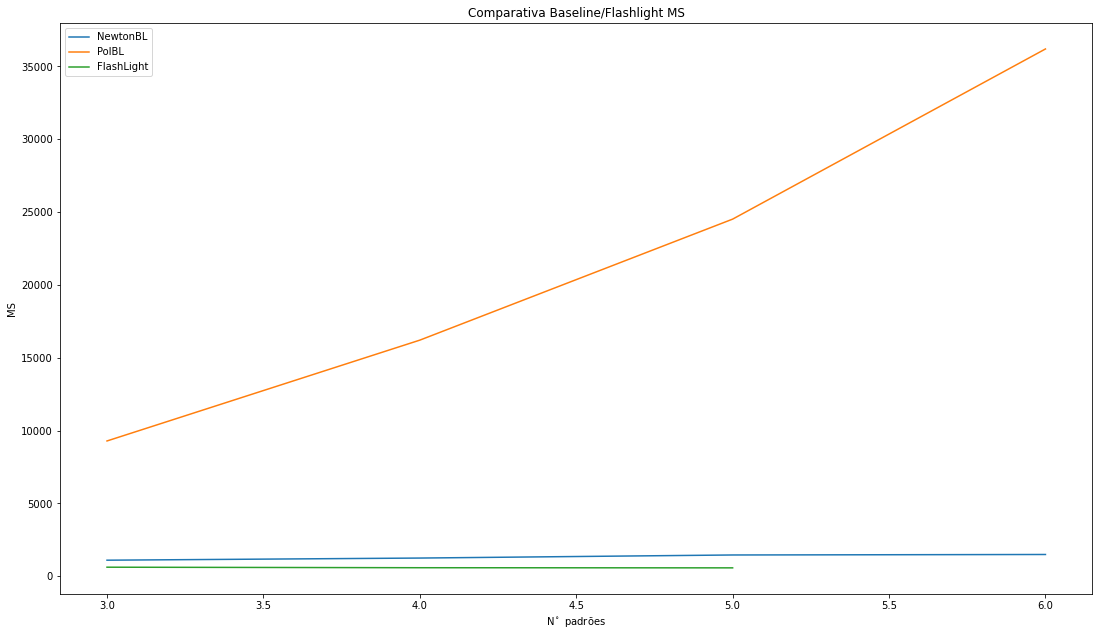

In [53]:
fig, ax = plt.subplots()
ax.set_title('Comparativa Baseline/Flashlight MS');
ax.set_ylabel('MS');
ax.set_xlabel('N$^\circ$ padrões')
ax.plot([3,4,5,6], newtonBaseLineMS, label='NewtonBL');
ax.plot([3,4,5,6], polinomialBaseLineMS, label='PolBL');
ax.plot([3,4,5], meanFlashLightMS, label='FlashLight');
plt.legend();
fig.set_size_inches(18.5, 10.5)



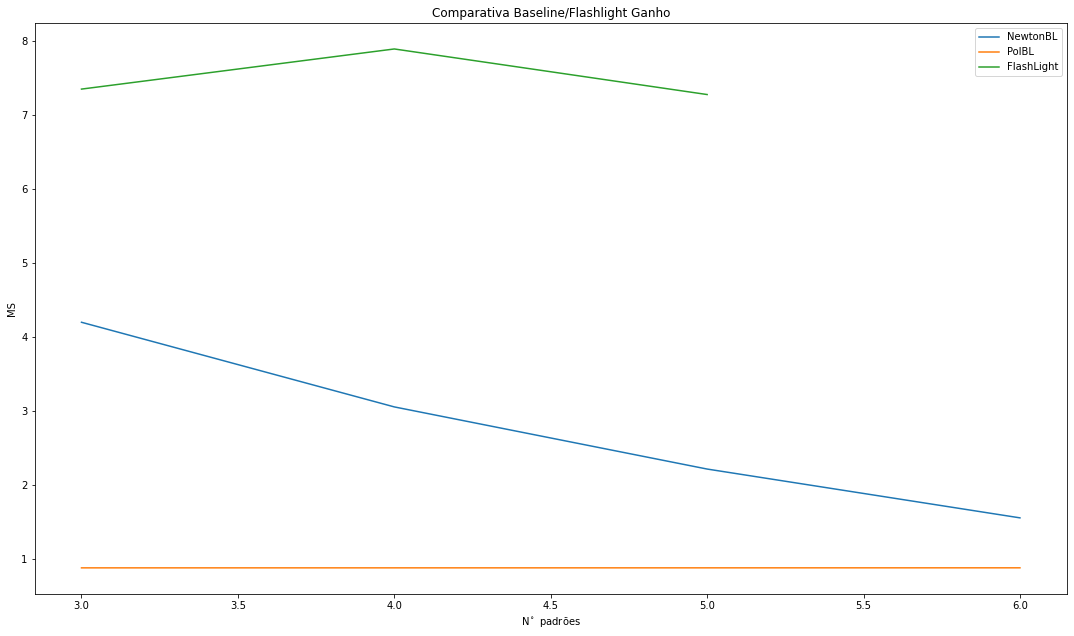

In [54]:
fig, ax = plt.subplots()
ax.set_title('Comparativa Baseline/Flashlight Ganho');
ax.set_ylabel('MS');
ax.set_xlabel('N$^\circ$ padrões')
ax.plot([3,4,5,6], newtonBaseLineGain, label='NewtonBL');
ax.plot([3,4,5,6], polinomialBaseLineGain, label='PolBL');
ax.plot([3,4,5], meanFlashLightGain, label='FlashLight');
plt.legend();
fig.set_size_inches(18.5, 10.5)


In [55]:
flashLightNumbers = pd.DataFrame({
    'Gain': [meanFlashLightMS[1], meanFlashLightMSS4, meanFlashLightMSS5],
    'MS' : [meanFlashLightGain[1],meanFlashLightGainS4, meanFlashLightGainS5],
    'Samples' : ['3','4','5'] 
});
flashLightNumbers

,Gain,MS,Samples
0,586.857700,7.891861,3
1,615.531267,6.180254,4
2,574.977833,7.230274,5
